# DistilBERT: Pre-trained Deep Learning Model

This practical is an adaption from: https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

Progress has been rapidly accelerating in machine learning models that process language over the last couple of years. This progress has left the research lab and started powering some of the leading digital products. A great example of this is the recent announcement of how the **BERT** (Bidirectional Encoder Representations from Transformers) model is now a major force behind Google Search. Google believes this step (or progress in natural language understanding as applied in search) represents “the biggest leap forward in the past five years, and one of the biggest leaps forward in the history of Search”.

One of the biggest challenges in NLP is the lack of enough training data. Overall there is enormous amount of text data available, but if we want to create task-specific datasets, we need to split that pile into the very many diverse fields. And when we do this, we end up with only a few thousand or a few hundred thousand human-labeled training examples. Unfortunately, in order to perform well, deep learning based NLP models require much larger amounts of data —  they see major improvements when trained on millions, or billions, of annotated training examples. To help bridge this gap in data, researchers have developed various techniques for training general purpose language representation models using the enormous piles of unannotated text on the web (this is known as pre-training). These general purpose pre-trained models can then be fine-tuned on smaller task-specific datasets, e.g., when working with problems like question answering and sentiment analysis. This approach results in great accuracy improvements compared to training on the smaller task-specific datasets from scratch. BERT is a recent addition to these techniques for NLP pre-training; it caused a stir in the deep learning community because it presented state-of-the-art results in a wide variety of NLP tasks, like question answering.

The best part about BERT is that it can be download and used for free —  we can either use the  BERT models to extract high quality language features from our text data, or we can fine-tune these models on a specific task, like sentiment analysis and question answering, with our own data to produce state-of-the-art predictions.

In this practical, we will use a variant of BERT to classify sentences. We will then use the output of that model to classify the text. The text is a list of sentences from film reviews. And we will classify each sentence as either speaking "positively" about its subject or "negatively".

Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). We can think of it as looking like this:

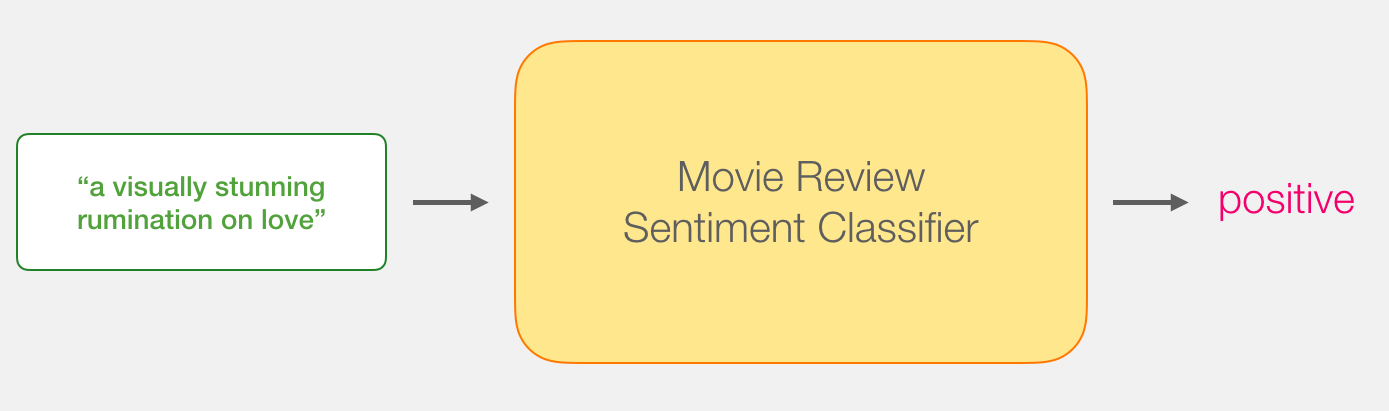

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.

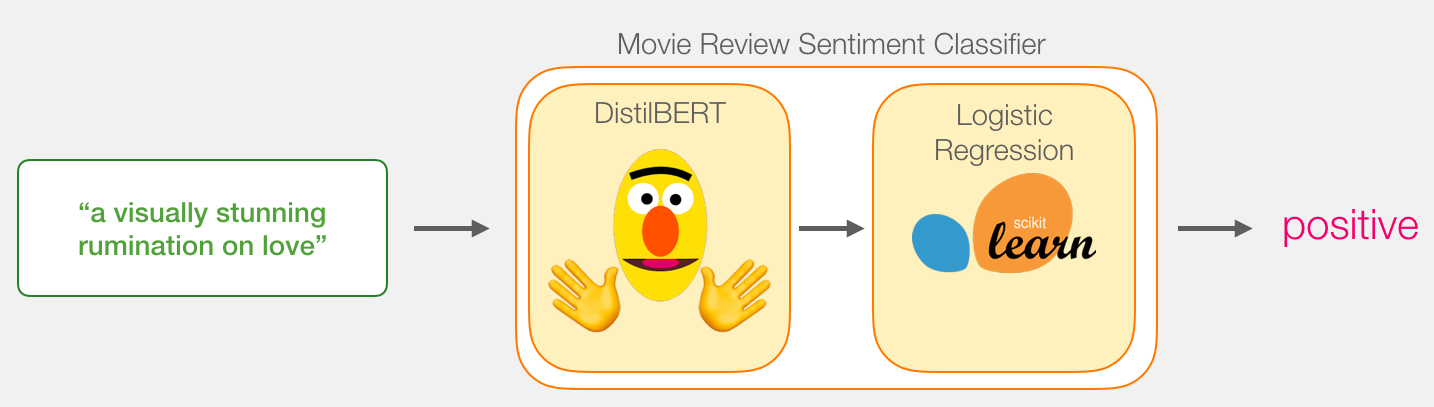

To learn more on BERT you can refer to this post: https://jalammar.github.io/illustrated-bert/

While we’ll be using two models, we will only train the logistic regression model. For DistillBERT, we’ll use a model that’s already pre-trained and has a grasp on the English language. This model, however is neither trained not fine-tuned to do sentence classification. We get some sentence classification capability, however, from the general objectives BERT is trained on. This is especially the case with BERT’s output for the first position (associated with the [CLS] token). I believe that’s due to BERT’s second training object – Next sentence classification. That objective seemingly trains the model to encapsulate a sentence-wide sense to the output at the first position. The transformers library provides us with an implementation of DistilBERT as well as pretrained versions of the model.

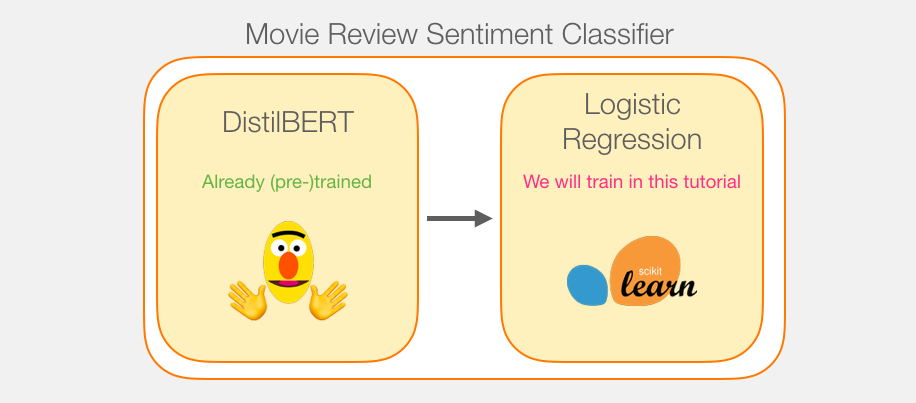

## Installing transformers library
You will need the huggingface transformers library to load the pre-trained BERT deep learning NLP model. To install the transformers library:

> pip install transformers

## Import libraries

~~~Python
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
~~~

## Dataset
The dataset we will use in this example is SST2, which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0). We'll use pandas to read the dataset and load it into a dataframe.

~~~Python
# importing dataset
df = pd.read_csv('train.tsv', delimiter='\t', header=None)
~~~

For performance reasons, we will only use 2000 sentences from the dataset and do a check on how many sentences are labeled as "positive" (value 1) and how many are labeled "negative" (having the value 0).
~~~Python
batch_1 = df[:2000]
batch_1[1].value_counts()
~~~

## Load Pre-trained BERT model
Let's now load a pre-trained BERT model.
~~~Python
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
~~~

We will use the trained distilBERT to generate sentence embeddings for 2,000 sentences.

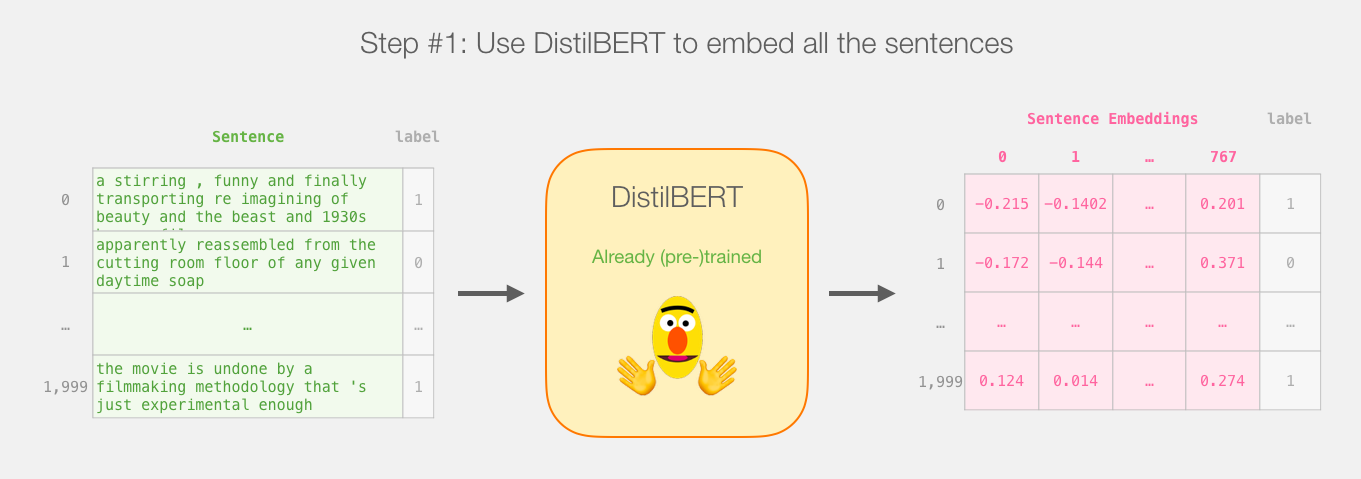

Let’s look at how a trained model calculates its prediction. 

Let’s try to classify the sentence “a visually stunning rumination on love”. The first step is to use the BERT tokenizer to first split the word into tokens. Then, we add the special tokens needed for sentence classifications (these are [CLS] at the first position, and [SEP] at the end of the sentence).

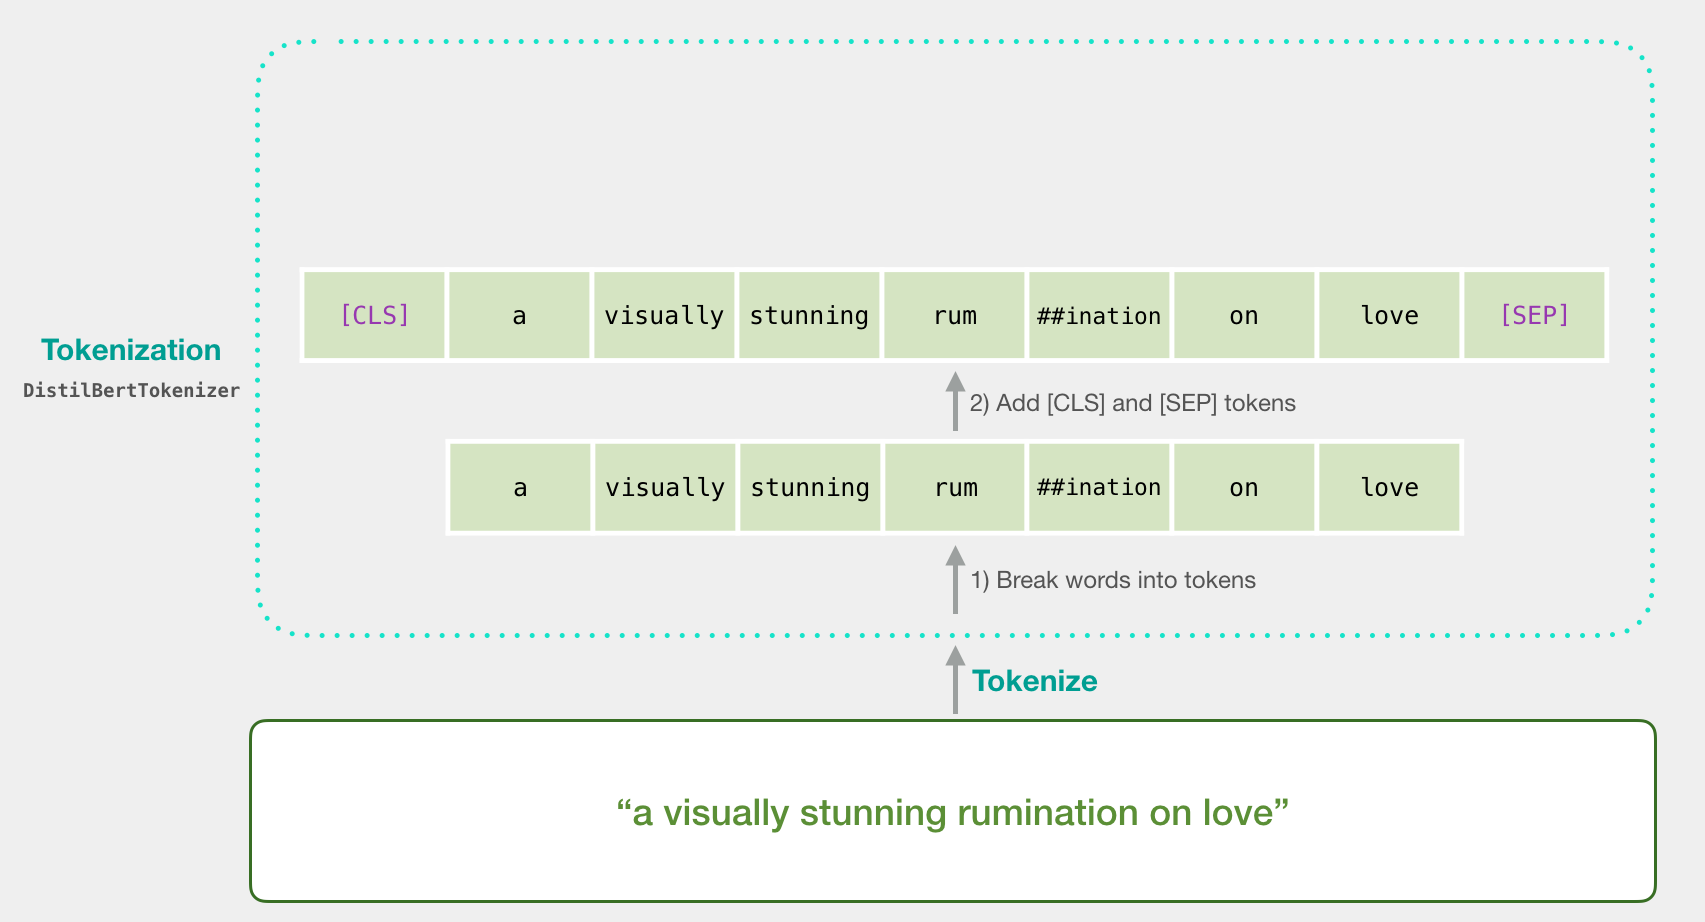

The third step the tokenizer does is to replace each token with its id from the embedding table which is a component we get with the trained model.

To learn more on word embeddings you can refer to this post: https://jalammar.github.io/illustrated-word2vec/

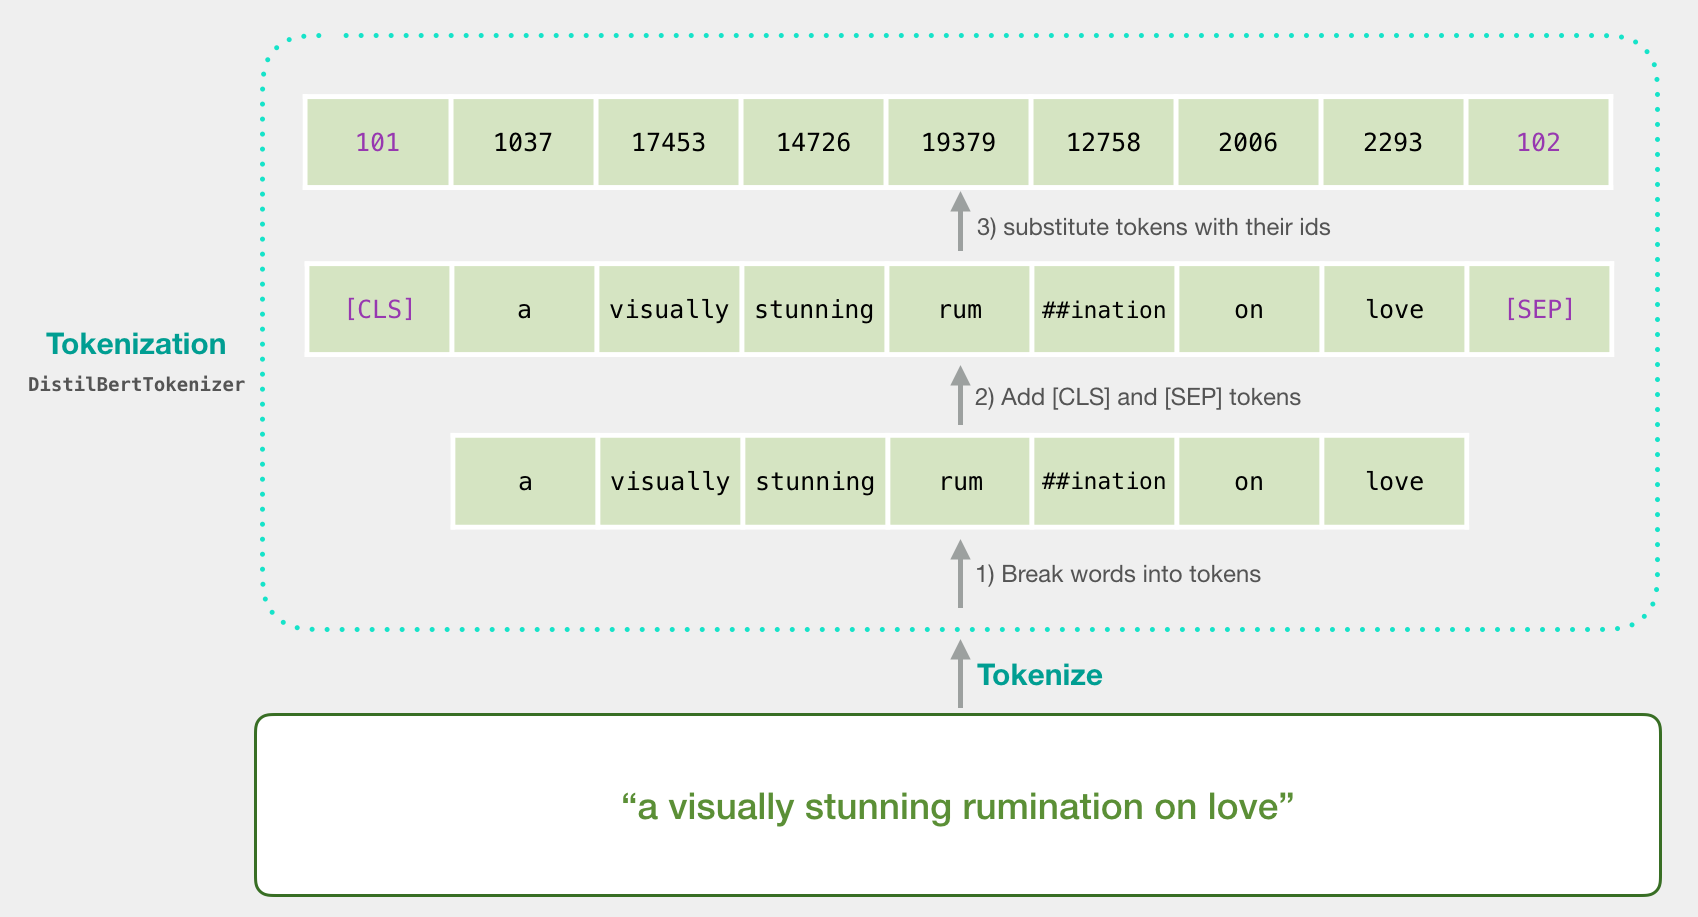

Note that the tokenizer does all these steps in a single line of code:
~~~Python
tokenizer.encode("a visually stunning rumination on love", add_special_tokens=True)
~~~
Our input sentence is now the proper shape to be passed to DistilBERT. This step can also be visualized in this manner:

![image.png](attachment:image.png)


Passing the input vector through DistilBERT works just like BERT. The output would be a vector for each input token. each vector is made up of 768 numbers (floats).

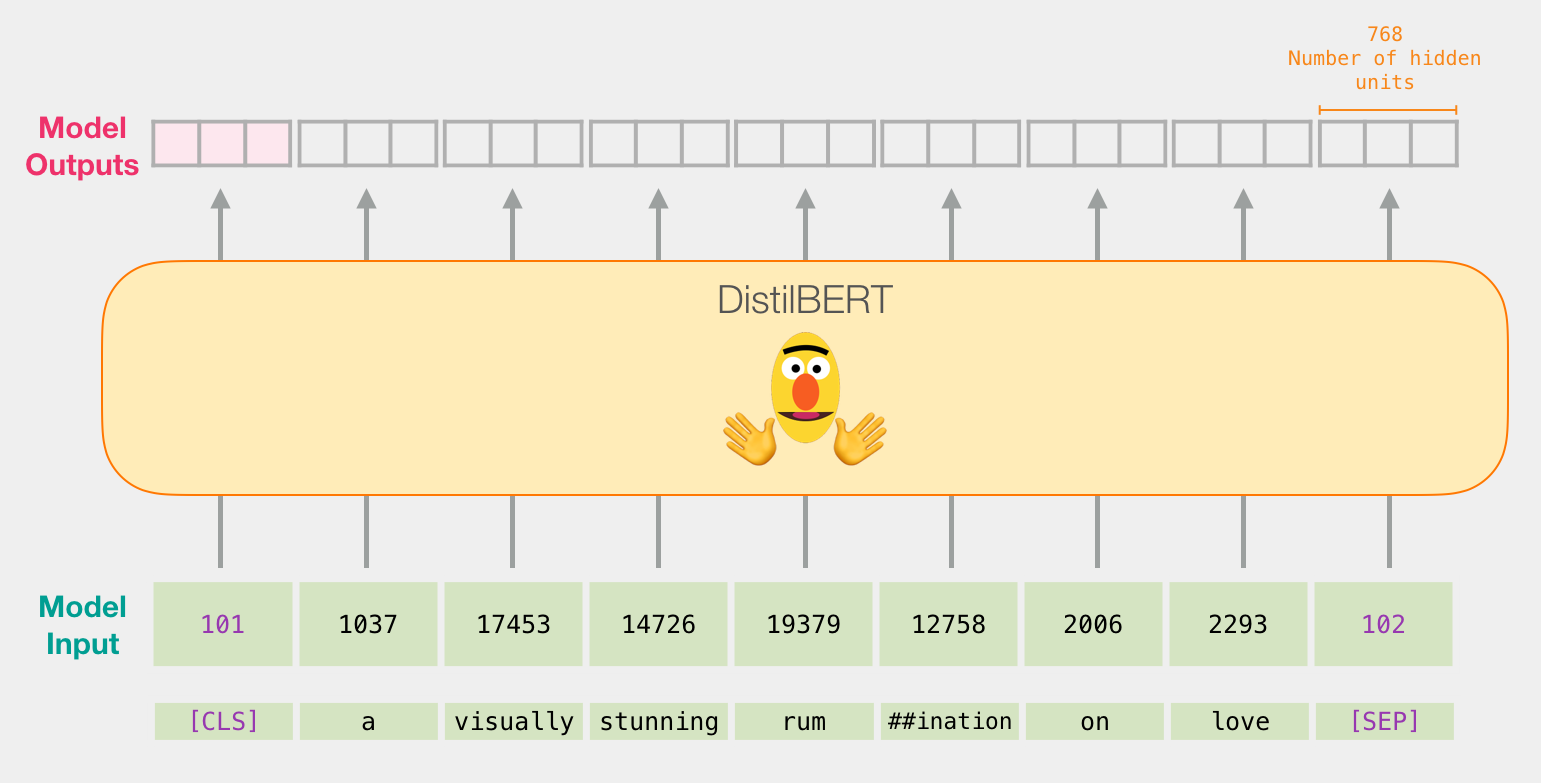

## Model #1: Preparing the Dataset
Before we can hand our sentences to BERT, we need to do some minimal processing to put them in the format it requires.

### Tokenisation
Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT prefers. This turns every sentence into the list of ids.

~~~Python
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
~~~

![image.png](attachment:image.png)

### Padding
After tokenization, tokenized is a list of sentences -- each sentences is represented as a list of tokens. The dataset is currently a list (or pandas Series/DataFrame) of lists. Before DistilBERT can process this as input, we’ll need to make all the vectors the same size by padding shorter sentences with the token id 0. You can refer to the notebook for the padding step, it’s basic python string and array manipulation.

After the padding, we have a matrix/tensor that is ready to be passed to BERT.

~~~Python
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

np.array(padded).shape
~~~

### Masking
If we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:
~~~Python
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape
~~~

### Build the model
Now that we have our model and inputs ready, let's run our model!

The model() function runs our sentences through BERT. The results of the processing will be returned into last_hidden_states.
~~~Python
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
~~~

After running this step, last_hidden_states holds the outputs of DistilBERT. It is a tuple with the shape (number of examples, max number of tokens in the sequence, number of hidden units in the DistilBERT model). In our case, this will be 2000 (since we only limited ourselves to 2000 examples), 66 (which is the number of tokens in the longest sequence from the 2000 examples), 768 (the number of hidden units in the DistilBERT model).

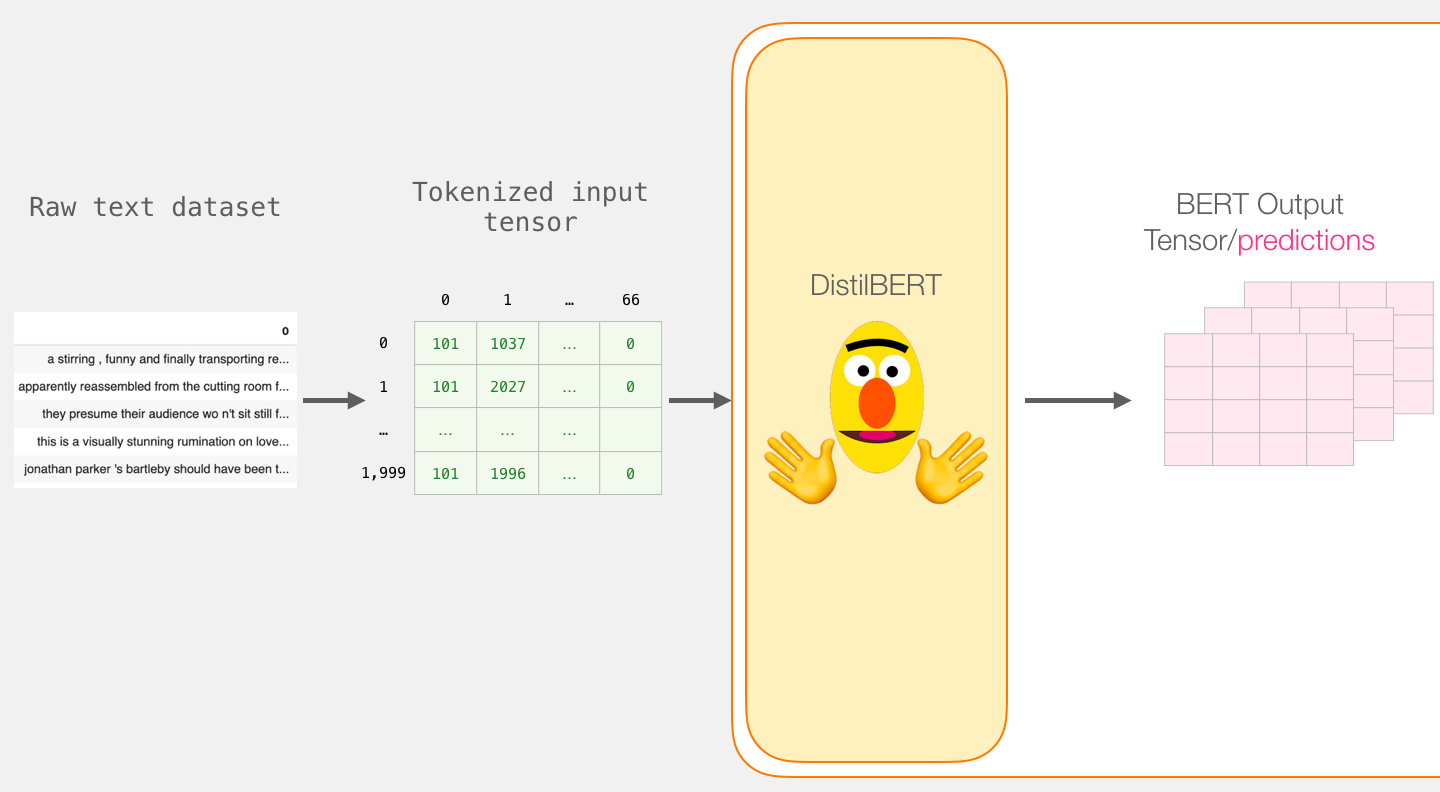

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

![image.png](attachment:image.png)

We'll save those in the features variable, as they'll serve as the features to our logitics regression model.

~~~Python
features = last_hidden_states[0][:,0,:].numpy()
~~~

And now features is a 2d numpy array containing the sentence embeddings of all the sentences in our dataset.

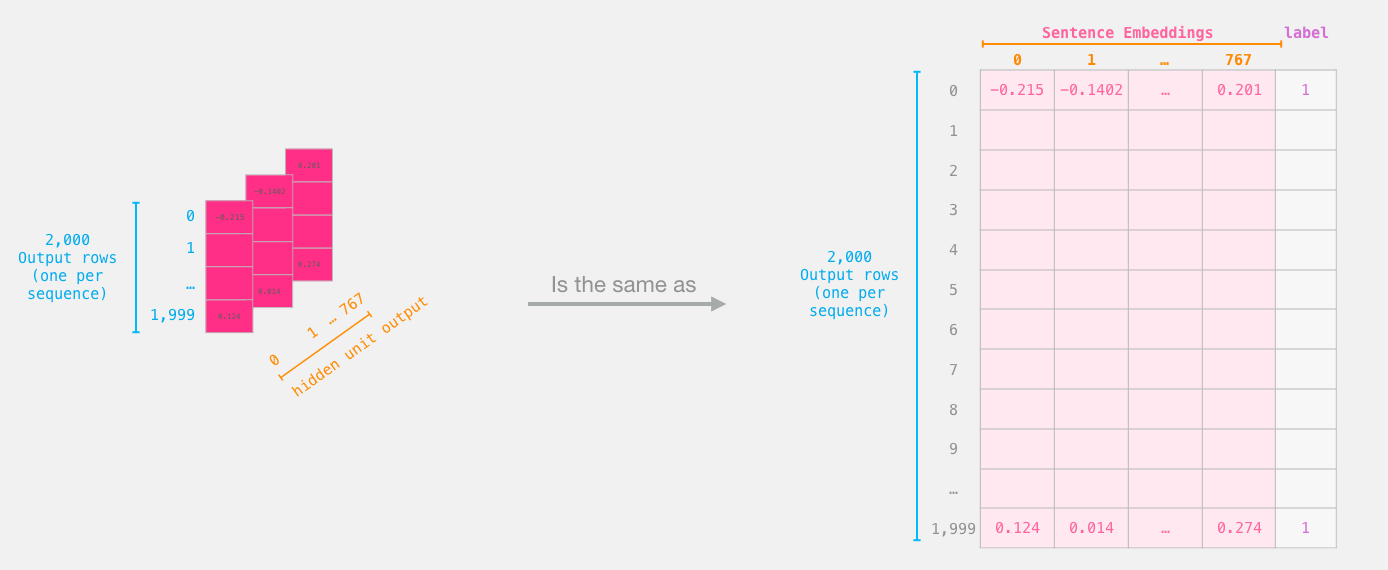

Now that we have the output of BERT, we have assembled the dataset we need to train our logistic regression model. The 768 columns are the features, and the labels we just get from our initial dataset.

![image.png](attachment:image.png)

The labels indicating which sentence is positive and negative now go into the labels variable
~~~Python
labels = batch_1[1]
~~~

## Model #2: Logistic Regression
Let's now split our datset into a training set and testing set (even though we're using 2,000 sentences from the SST2 training set).

~~~Python
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
~~~

![image.png](attachment:image.png)

### Grid Search for Parameters
We can dive into Logistic regression directly with the Scikit Learn default parameters, but sometimes it's worth searching for the best value of the C parameter, which determines regularization strength.

~~~Python
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)
~~~

We now train the LogisticRegression mode and plug the value of C into the model declaration.

~~~Python
lr_clf = LogisticRegression(C=5.2)
lr_clf.fit(train_features, train_labels)
~~~

Now that the model is trained, we can score it against the test set:
~~~Python
lr_clf.score(test_features, test_labels)
~~~

For reference, the highest accuracy score for this dataset is currently 96.8. DistilBERT can be trained to improve its score on this task – a process called fine-tuning which updates BERT’s weights to make it achieve a better performance in this sentence classification task (which we can call the downstream task). The fine-tuned DistilBERT turns out to achieve an accuracy score of 90.7. The full size BERT model achieves 94.9.

And that’s it! That’s a good first contact with BERT. The next step would be to head over to the documentation and try your hand at fine-tuning. You can also go back and switch from distilBERT to BERT and see how that works.